# Introduction

The SenNet Data Sharing Portal (https://data.sennetconsortium.org/) is a central platform developed by the NIH-funded Cellular Senescence Network (SenNet, https://sennetconsortium.org/) to support collaborative research on cellular senescence. It enables researchers to share and access a wide array of high-resolution datasets, including single-cell RNA sequencing, spatial transcriptomics, proteomics, and imaging data. A major objective of the portal is to facilitate the creation of maps that illustrate the spatial and temporal distribution of senescent cells across different tissues and physiological conditions.

The portal offers interactive data access as well as tools and APIs for programmatic data access, allowing users to efficiently search, retrieve, and analyze data. It also provides detailed documentation and submission guidelines for data contributors. Upon curation and processing the data is continuously made available to the public through the portal, promoting transparency and broader scientific collaboration.

## Use case

The SenNet Data Sharing Portal (https://data.sennetconsortium.org/) was used to query IDs of all kidney datasets generated by UConn Health TMC.
Each found SenNet dataset is associated with **`sennet_id`** and **`uuid`**. The example below shows dataset `SNT224.LSLK.429`, where its associated Lab ID is downloaded to TSV file.

The goal is to find Donor metadata associated with each of the found dataset IDs.

## Exploring the data programmatically

The downloaded TSV file is loaded with a python library `pandas`. The basic metadata can be viewed in the loaded data table. SenNet serves several Application Programming Interfaces (API), allowing the users to find files associated with datasets and any other relevant entities.

The basic workflow is to identify any derived datasets for the **SenNet ID** of interest, and then identify sources associated with the dataset.

First, load the datasets IDs from the TSV file, earlier derived via the Portal.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke

wdir = './notebooks'
se_ids_of_interest = pd.read_csv(f'{wdir}/kidney-43-datasets.tsv',
                                delimiter='\t', index_col='SenNet ID')['Lab Dataset ID']
se_ids_of_interest.head(1).to_dict()

{'SNT224.LSLK.429': 'SA_WLK_019_u_he'}

Use the "Entity" API to query the SenNet IDs of interest

In [2]:
import requests
from tqdm import tqdm

def get_source_metadata(uuid, sample_category=None):
    url = f"https://entity.api.sennetconsortium.org/ancestors/{uuid}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        try:
            temp = [v for v in data if 'source_type' in v.keys()][0]
            if 'organ_donor_data' in temp['metadata'].keys():
                k = 'organ_donor_data'
            elif 'living_donor_data' in temp['metadata'].keys():
                k = 'living_donor_data'
            df = pd.DataFrame(temp['metadata'][k]).set_index('grouping_concept_preferred_term')[['data_value', 'units']]
            se_units = df['units'].astype(str)
            wh = se_units != ''
            se_units[wh] = '(' + se_units[wh] + ')'
            df.index += se_units
            se = df['data_value']
            se['Donor ID'] = temp['sennet_id']
            se = se.groupby(level=0).agg(lambda x: '; '.join(x) if isinstance(x, pd.Series) else x)
        except Exception as exception:
            print(exception)
            se = None
    else:
        se = None
        print(f"Failed to retrieve data: {response.status_code}")
    return se

Retrieve metadata for each SenNet ID of interest and compile it into a DataFrame

In [3]:
ses = []
for sennet_id in tqdm(se_ids_of_interest.index):
    try:
        se = get_source_metadata(sennet_id, sample_category='source')
        if se is not None:
            se['SenNet ID'] = sennet_id
            se['Lab ID'] = se_ids_of_interest.loc[sennet_id]
            ses.append(se)
    except Exception as e:
        print(f"Error processing {sennet_id}: {e}")
df = pd.DataFrame(ses).set_index(['Donor ID', 'SenNet ID', 'Lab ID']).sort_index().fillna('')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:06<00:00,  6.31it/s]


In [4]:
df

ABO blood group system  \
Donor ID        SenNet ID       Lab ID                                      
SNT249.HVPS.886 SNT995.TNZG.284 JAX-019-KD-C_he                             
SNT286.ZMFZ.764 SNT795.VWXG.278 JAX-016-KD-C_he                             
SNT328.TVQR.548 SNT754.PPDD.396 JAX-003-KD-C_he                             
SNT365.SNNH.787 SNT638.SQRR.322 JAX-008-KD-C_he                             
SNT367.QWKK.553 SNT224.LSLK.429 SA_WLK_019_u_he              Blood Type A   
                SNT284.CXBG.892 SA_WLK_019_g_he              Blood Type A   
                SNT338.DWSW.624 SA_WLK_019_e_he              Blood Type A   
                SNT357.RMGR.386 SA_WLK_019_b_he              Blood Type A   
                SNT364.PPVT.683 SA_WLK_019_v_he              Blood Type A   
                SNT395.QVXS.675 SA_WLK_019_r_he              Blood Type A   
                SNT398.XTWP.354 SA_WLK_019_mnop_he           Blood Type A   
                SNT473.ZKTZ.763  SA_WLK_019_k_he             Blood Type A   
                SNT536.RWZB.259 SA_WLK_019_j_he              Blood Type A   
                SNT539.FPFZ.858 SA_WLK_019_i_he              Blood Type A   
                SNT566.NWDW.327 SA_WLK_019_f_he              Blood Type A   
                SNT576.HVQX.276 SA_WLK_019_s_he              Blood Type A   
                SNT595.ZVCR.673 SA_WLK_019_c_he              Blood Type A   
                SNT623.PDFL.545 SA_WLK_019_t_he              Blood Type A   
                SNT624.LBZT.775 SA_WLK_019_h_he              Blood Type A   
                SNT626.VPNG.354 SA_WLK_019_l_he              Blood Type A   
                SNT677.WCHJ.569 SA_WLK_019_q_he              Blood Type A   
                SNT747.DFQV.649 SA_WLK_019_a_he              Blood Type A   
                SNT843.MNXH.862 SA_WLK_019_d_he              Blood Type A   
                SNT922.MBDC.543 SA_WLK_019_w_he              Blood Type A   
SNT372.GFLT.786 SNT823.QKZW.428 JAX-007-KD-C_he                             
SNT375.GLDQ.824 SNT935.GZLP.764 JAX-021-KD-C_he                             
SNT384.NSRG.746 SNT459.NPPW.289 JAX-020-KD-C_he                             
SNT393.ZPLM.437 SNT435.WNSP.922 JAX-023-KD-C_he                             
SNT445.SDXH.983 SNT556.PNQL.927 JAX-005-KD-C_he                             
SNT455.FPNZ.266 SNT245.SNLH.487 JAX-012-KD-C_he                             
SNT559.NTKJ.844 SNT739.GKTW.343 JAX-009-KD-C_he                             
SNT563.JDFJ.285 SNT465.CZLC.453 JAX-022-KD-C_he                             
SNT573.MWRR.888 SNT458.JMZM.278 JAX-011-KD-C_he                             
SNT643.MCLV.222 SNT643.KSKX.834 JAX-006-KD-C_he                             
SNT662.MCTS.449 SNT662.MHTK.983 JAX-013-KD-C_he                             
SNT687.VJCB.497 SNT765.LLKR.337 JAX-017-KD-C_he                             
SNT856.CHSB.526 SNT243.CCNV.683 JAX-015-KD-C_he                             
SNT882.VCZB.445 SNT347.VMQL.936 JAX-014-KD-C_he                             
SNT923.FMVH.242 SNT462.NKGL.285 JAX-002-KD-C_he                             
SNT936.SBVG.368 SNT282.BMNB.867 JAX-024-KD-C_he                             
SNT978.PZNC.359 SNT495.TTVG.832 JAX-004-KD-C_he                             
SNT994.VLRL.323 SNT727.BRLL.676 JAX-010-KD-C_he                             
SNT995.WTXN.587 SNT937.KXMC.967 JAX-018-KD-C_he                             

                                                   Age(years)  \
Donor ID        SenNet ID       Lab ID                          
SNT249.HVPS.886 SNT995.TNZG.284 JAX-019-KD-C_he            30   
SNT286.ZMFZ.764 SNT795.VWXG.278 JAX-016-KD-C_he            37   
SNT328.TVQR.548 SNT754.PPDD.396 JAX-003-KD-C_he            60   
SNT365.SNNH.787 SNT638.SQRR.322 JAX-008-KD-C_he            63   
SNT367.QWKK.553 SNT224.LSLK.429 SA_WLK_019_u_he            49   
                SNT284.CXBG.892 SA_WLK_019_g_he            49   
                SNT338.DWSW.624 SA_WLK_019_e_he            49   


In [5]:
# Group by 'Donor ID' and take the first occurrence of each group, to keep only one entry per donor.
dfg = df.reset_index('Lab ID').groupby(level=0).first()
dfg['Lab ID'] = dfg['Lab ID'].str.replace('_', '-').apply(lambda x: '-'.join(x.split('-')[:3]))
print(dfg.shape)
dfg

(24, 15)


,Lab ID,ABO blood group system,Age(years),Body Mass Index(kg/m2),Cause of Death,Ethnicity,HbA1c(%),Height(cm),Mechanism of Injury,Medical History,Race,Rh Blood Group,Sex,Social History,Weight(kg)
Donor ID,,,,,,,,,,,,,,,
SNT249.HVPS.886,JAX-019-KD,,30,32,,Hispanic or Latino,,166,,Family history of kidney disease,White,,Male,Smoker,88.3
SNT286.ZMFZ.764,JAX-016-KD,,37,32.7,,Hispanic or Latino,,160,,,White,,Female,Smoker,83.7
SNT328.TVQR.548,JAX-003-KD,,60,29.9,,Not Hispanic or Latino,,154,,Hypertension,Asian,,Female,,70.9
SNT365.SNNH.787,JAX-008-KD,,63,25,,,,162.6,,,White,,Female,,66.1
SNT367.QWKK.553,SA-WLK-019,Blood Type A,49,28.5,Cerebrovascular accident,Hispanic or Latino,10.2,171,Intracranial hemorrhage,Hypertension; Hyperlipidimia; Type 2 Diabetes ...,White,Rh positive,Male,Smoker; Alcohol use,83.3
SNT372.GFLT.786,JAX-007-KD,,31,22.9,,Hispanic or Latino,,162,,Family history of kidney disease,White,,Female,,60.1
SNT375.GLDQ.824,JAX-021-KD,,42,21.4,,Hispanic or Latino,,157,,,White,,Female,Smoker,52.8
SNT384.NSRG.746,JAX-020-KD,,30,29.2,,Hispanic or Latino,,154,,COVID-19,White,,Female,,69.2
SNT393.ZPLM.437,JAX-023-KD,,25,24.3,,Hispanic or Latino,,161,,Family history of kidney disease,White,,Male,Smoker,63.1


In [6]:
# plt.rcParams['figure.dpi'] = 150

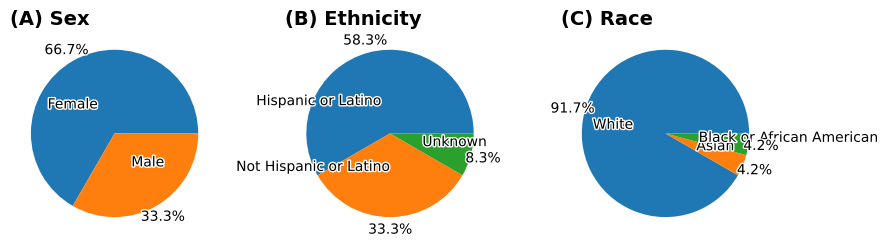

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(3*3, 3))
params = dict(autopct='%1.1f%%', pctdistance=1.15, labeldistance=.4)
outline = [withStroke(linewidth=2, foreground='white')]
panels = ['A', 'B', 'C']
for i, identity in enumerate(['Sex', 'Ethnicity', 'Race']):
    se = dfg[identity].replace('', 'Unknown').value_counts()
    wedges, texts, autotexts = axs[i].pie(se.values, labels=se.index, **params)
    for text in texts + autotexts:
        text.set_path_effects(outline)
    axs[i].text(axs[i].get_xlim()[0], axs[i].get_ylim()[1], f'({panels[i]}) {identity}', ha='left', va='bottom', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


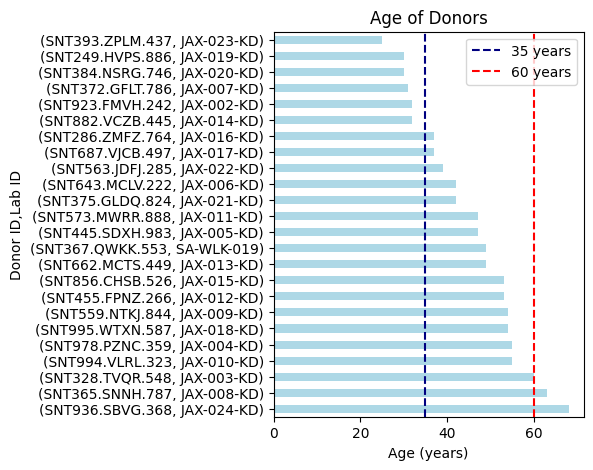

In [8]:
dfg.set_index('Lab ID', append=True)['Age(years)'].sort_values(ascending=False).astype(int).plot(kind='barh', figsize=(4, 5), title='Age of Donors', color='lightblue', label='')
ax = plt.gca()
ax.axvline(35, color='navy', linestyle='--', label='35 years')
ax.axvline(60, color='red', linestyle='--', label='60 years')
ax.set_xlabel('Age (years)')
plt.legend()
plt.show()

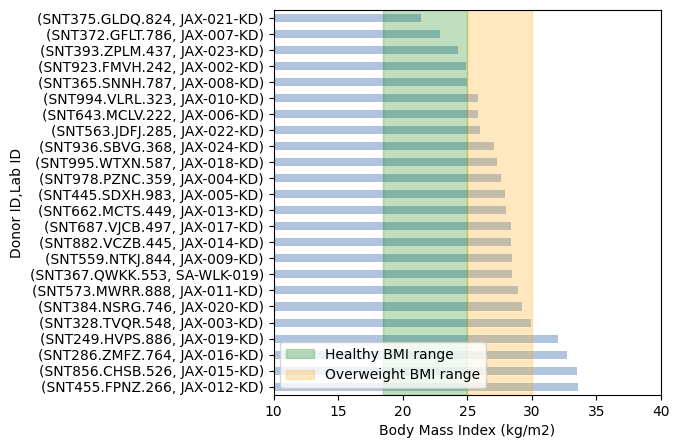

In [9]:
dfg.set_index('Lab ID', append=True)['Body Mass Index(kg/m2)'].sort_values(ascending=False).astype(float).plot(kind='barh', figsize=(5, 5), title='', color='lightsteelblue', label='')
ax = plt.gca()
ax.axvspan(18.5, 25, color='green', alpha=0.25, label='Healthy BMI range')
ax.axvspan(25, 30, color='orange', alpha=0.25, label='Overweight BMI range')
ax.set_xlim(left=10, right=40)
plt.xlabel('Body Mass Index (kg/m2)')
plt.legend(loc='lower left')
plt.show()